<a href="https://colab.research.google.com/github/RajiRai/GenAI-Tutorial/blob/main/GenAI_July16.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! pip install cohere altair


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.5/178.5 kB 3.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.2/139.2 kB 16.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 33.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 9.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 46.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.7/82.7 kB 9.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 9.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 7.1 MB/s eta 0:00:00


In [ ]:
# /content/drive/MyDrive/GENAI-RAW/atis_intents_train.csv

import cohere
import altair as alt
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans

In [ ]:
from google.colab import userdata
key = userdata.get('Cohere_key')

co=cohere.Client(key)

In [ ]:
df_orig = pd.read_csv('/content/drive/MyDrive/GENAI-RAW/atis_intents_train.csv')
df_orig.head()



,atis_flight,i want to fly from boston at 838 am and arrive in denver at 1110 in the morning
0,atis_flight,what flights are available from pittsburgh to...
1,atis_flight_time,what is the arrival time in san francisco for...
2,atis_airfare,cheapest airfare from tacoma to orlando
3,atis_airfare,round trip fares from pittsburgh to philadelp...
4,atis_flight,i need a flight tomorrow from columbus to min...


In [ ]:
# data cleansing

df_orig = pd.read_csv('/content/drive/MyDrive/GENAI-RAW/atis_intents_train.csv' , names = ['intent','query'])

df_orig.head()

,intent,query
0,atis_flight,i want to fly from boston at 838 am and arriv...
1,atis_flight,what flights are available from pittsburgh to...
2,atis_flight_time,what is the arrival time in san francisco for...
3,atis_airfare,cheapest airfare from tacoma to orlando
4,atis_airfare,round trip fares from pittsburgh to philadelp...


In [ ]:
sample_classes = ['atis_airfare', 'atis_airline', 'atis_ground_service']

df=df_orig.sample(frac=0.1, random_state=30)
df=df[df['intent'].isin(sample_classes)]
df.head()


,intent,query
2570,atis_airline,which airlines fly from boston to washington ...
1146,atis_airline,show me the airlines that fly between toronto...
3223,atis_airfare,show me round trip first class tickets from n...
4367,atis_airfare,i'd like the lowest fare from denver to pitts...
2205,atis_ground_service,show me a list of ground transportation at bo...


In [ ]:
df_orig=df_orig.drop(df.index)

In [ ]:
df.reset_index(drop=True, inplace=True)
df.head()

,intent,query
0,atis_airline,which airlines fly from boston to washington ...
1,atis_airline,show me the airlines that fly between toronto...
2,atis_airfare,show me round trip first class tickets from n...
3,atis_airfare,i'd like the lowest fare from denver to pitts...
4,atis_ground_service,show me a list of ground transportation at bo...


In [ ]:
# remove unwanted columns

intent=df['intent']
df.drop('intent', axis=1,inplace=True)
df.head()

,query
0,which airlines fly from boston to washington ...
1,show me the airlines that fly between toronto...
2,show me round trip first class tickets from n...
3,i'd like the lowest fare from denver to pitts...
4,show me a list of ground transportation at bo...


In [ ]:
for i in df.head(10)["query"]:
  print(i)

 which airlines fly from boston to washington dc via other cities
 show me the airlines that fly between toronto and denver
 show me round trip first class tickets from new york to miami
 i'd like the lowest fare from denver to pittsburgh
 show me a list of ground transportation at boston airport
 show me boston ground transportation
 of all airlines which airline has the most arrivals in atlanta
 what ground transportation is available in boston
 i would like your rates between atlanta and boston on september third
 which airlines fly between boston and pittsburgh


In [ ]:
#convert text to embeddings

def get_embeddings(texts,model='embed-english-v3.0',input_type="search_document") :
  output = co.embed(texts=texts, model=model, input_type=input_type)
  return output.embeddings




In [ ]:
#embed the dataset
df['query_embeds'] = get_embeddings(df['query'].tolist())
df.head()

,query,query_embeds
0,which airlines fly from boston to washington ...,"[0.026550293, 0.012084961, -0.00881958, 0.0113..."
1,show me the airlines that fly between toronto...,"[0.013084412, 0.01776123, -0.014343262, -0.003..."
2,show me round trip first class tickets from n...,"[0.02053833, -0.038482666, 0.061523438, 0.0099..."
3,i'd like the lowest fare from denver to pitts...,"[0.0016889572, 0.015411377, -0.029052734, 0.03..."
4,show me a list of ground transportation at bo...,"[0.03793335, -0.008010864, -0.002319336, -0.01..."


In [ ]:
# visualize embeddings using heatmap
# reduce dimensions without data loss using PCA

def get_pc(arr, n) :
  pca=PCA(n_components=n)
  embeds_transform=pca.fit_transform(arr)
  return embeds_transform

In [ ]:
# reduce dimensions to 10 principal components

embeds=np.array(df['query_embeds'].tolist())
embeds_pc=get_pc(embeds, 10)

In [ ]:
# set the sample size to visualize

sample = 9
source = pd.DataFrame(embeds_pc)[:sample]
source=pd.concat([source, df['query']], axis=1)
source=source.melt(id_vars='query')

#configure the plot

chart=alt.Chart(source).mark_rect().encode(
x=alt.X('variable:N', title='Embedding'),
y=alt.Y('query:N', title="", axis=alt.Axis(labelLimit=500)),
color=alt.Color('value:Q', title="Value", scale=alt.Scale(scheme='blueorange')

)
)


result = chart.configure(background='#ffffff').properties(
    width=500,
    height=500,
    title="Emebedding with 10 dimensions"
).configure_axis(labelFontSize=10, titleFontSize=10)

result

alt.Chart(...)

In [ ]:
# Function to generate the 2D plot
def generate_chart(df,xcol,ycol,lbl='on',color='basic',title=''):
    chart = alt.Chart(df).mark_circle(size=500).encode(
        x=
        alt.X(xcol,
              scale=alt.Scale(zero=False),
              axis=alt.Axis(labels=False, ticks=False, domain=False)
             ),
        y=
        alt.Y(ycol,
              scale=alt.Scale(zero=False),
              axis=alt.Axis(labels=False, ticks=False, domain=False)
             ),
        color= alt.value('#333293') if color == 'basic' else color,
        tooltip=['query']
    )

    if lbl == 'on':
        text = chart.mark_text(align='left', baseline='middle',dx=15, size=13,color='black').encode(text='query', color= alt.value('black'))
    else:
        text = chart.mark_text(align='left', baseline='middle',dx=10).encode()

    result = (chart + text).configure(background="#FDF7F0").properties(
        width=800,
        height=500,
        title=title
    ).configure_legend(orient='bottom', titleFontSize=18,labelFontSize=18)

    return result

In [ ]:
# Reduce embeddings to 2 PC to support visualization

embeds_pc2=get_pc(embeds, 2)

df_pc2=pd.concat([df,pd.DataFrame(embeds_pc2)],axis=1)
df_pc2.columns = df_pc2.columns.astype(str)
generate_chart(df_pc2.iloc[:sample],'0','1',title = "Embeddings with 2 dimensions")


alt.LayerChart(...)

In [ ]:
# Embed the search query

# Define the query

new_query="How can I find a taxi or bus when the plane lands?"



In [ ]:
new_query_embeds=get_embeddings([new_query], input_type="search_query") [0]


In [ ]:
def get_similarity(target,candidates):
  candidates=np.array(candidates)
  target=np.expand_dims(np.array(target),axis=0)

  sim=cosine_similarity(target,candidates)
  sim=np.squeeze(sim).tolist()
  sort_index=np.argsort(sim)[::-1]
  sort_score=[sim[i] for i in sort_index]
  similarity_score=zip(sort_index,sort_score)
  return similarity_score


In [ ]:
similarity=get_similarity(new_query_embeds, embeds[:sample])

In [ ]:
print("Query :")
print(new_query, "\n")

print("Similar document matched:")

for idx, sim in similarity:
  print(f"Similarity:{sim:.2f}-{df['query'][idx]}")

Query :
How can I find a taxi or bus when the plane lands? 

Similar document matched:
Similarity:0.37- show me a list of ground transportation at boston airport
Similarity:0.36- what ground transportation is available in boston
Similarity:0.33- show me boston ground transportation
Similarity:0.27- show me the airlines that fly between toronto and denver
Similarity:0.25- which airlines fly from boston to washington dc via other cities
Similarity:0.24- of all airlines which airline has the most arrivals in atlanta
Similarity:0.19- i'd like the lowest fare from denver to pittsburgh
Similarity:0.17- show me round trip first class tickets from new york to miami
Similarity:0.17- i would like your rates between atlanta and boston on september third


In [ ]:
# visualze

df_sem=df.copy()
df_sem.loc[len(df_sem.index)]=[new_query,new_query_embeds]

embeds_sem=np.array(df_sem['query_embeds'].tolist())
embeds_sem_pc2=get_pc(embeds_sem,2)

df_sem_pc2=pd.concat([df_sem,pd.DataFrame(embeds_sem_pc2)],axis=1)
df_sem_pc2

,query,query_embeds,0,1
0,which airlines fly from boston to washington ...,"[0.026550293, 0.012084961, -0.00881958, 0.0113...",-0.079135,0.235580
1,show me the airlines that fly between toronto...,"[0.013084412, 0.01776123, -0.014343262, -0.003...",-0.008991,0.325411
2,show me round trip first class tickets from n...,"[0.02053833, -0.038482666, 0.061523438, 0.0099...",-0.199780,-0.063866
3,i'd like the lowest fare from denver to pitts...,"[0.0016889572, 0.015411377, -0.029052734, 0.03...",-0.114206,-0.201392
4,show me a list of ground transportation at bo...,"[0.03793335, -0.008010864, -0.002319336, -0.01...",0.310613,0.220207
...,...,...,...,...
87,can i take a single airline from la to charlo...,"[-0.0037574768, -0.031707764, -0.008331299, 0....",-0.131875,0.168480
88,what is the cost for a one way trip from pitt...,"[0.02848816, -0.015640259, 0.0073165894, 0.009...",-0.231507,-0.180931
89,what ground transportation is available in ba...,"[0.019744873, 0.012123108, -0.03164673, -0.027...",0.473122,-0.203406
90,give me the round trip coach fare from baltim...,"[0.031280518, -0.009346008, -0.009613037, 0.01...",-0.104809,-0.234210


In [ ]:
df_sem_pc2["Source"]="Existing"
df_sem_pc2.at[len(df_sem_pc2)-1, "Source"] = "New"

df_sem_pc2.columns = df_sem_pc2.columns.astype(str)
selection=list(range(sample))+[-1]

generate_chart(df_sem_pc2.iloc[selection],'0','1', color='Source', title="Semantic search")

alt.LayerChart(...)

In [ ]:
# Use Input type as clustering

df['clustering_embeds']=get_embeddings(df['query'].tolist(),input_type="clustering")
embeds=np.array(df['clustering_embeds'].tolist())


In [ ]:
n_clusters = 2

kmeans_model=KMeans(n_clusters=n_clusters, n_init='auto',random_state=0)
classes = kmeans_model.fit_predict(embeds).tolist()

df_clust=df_pc2.copy()
df_clust['cluster']=(list(map(str,classes)))
df_clust.head()


,query,query_embeds,0,1,cluster
0,which airlines fly from boston to washington ...,"[0.026550293, 0.012084961, -0.00881958, 0.0113...",-0.073104,0.251087,1
1,show me the airlines that fly between toronto...,"[0.013084412, 0.01776123, -0.014343262, -0.003...",-0.006073,0.317884,1
2,show me round trip first class tickets from n...,"[0.02053833, -0.038482666, 0.061523438, 0.0099...",-0.195818,-0.080082,1
3,i'd like the lowest fare from denver to pitts...,"[0.0016889572, 0.015411377, -0.029052734, 0.03...",-0.111862,-0.206357,1
4,show me a list of ground transportation at bo...,"[0.03793335, -0.008010864, -0.002319336, -0.01...",0.314424,0.227129,0


In [ ]:
#plot

df_clust.columns = df_clust.columns.astype(str)
generate_chart(df_clust.iloc[:sample],'0','1', color='cluster',title="clustering with 2 clusters")

alt.LayerChart(...)

In [ ]:
# chat() vs chat_stream()

def generate_text(message):
  stream = co.chat_stream(message=message,model="command-r-plus")
  for event in stream:
    if event.event_type == "text-generation":
      print(event.text, end=' ')

generate_text("How can I find a taxi or a bus when the plane lands?")


When  you  arrive  at  your  destination  airport ,  there  are  several  ways  to  find  transportation  to  your  next  location : 

-  Taxi :  Most  airports  have  a  designated  taxi  stand  or  queue .  Look  for  signs  or  ask  an  airport  staff  member  to  direct  you  to  the  taxi  pickup  area .  You  can  usually  find  a  line  of  taxis  waiting  for  passengers .  Some  airports  also  offer  ride - h ailing  services  like  Uber  or  Lyft ,  which  you  can  request  through  their  respective  apps . 

-  Bus :  Many  airports  are  connected  to  the  local  public  transportation  system .  Look  for  signs  or  ask  for  directions  to  the  bus  stop  or  station .  You  can  usually  find  information  about  bus  routes  and  schedules  on  the  airport 's  website  or  through  local  transit  authorities .  Some  airports  also  offer  shuttle  bus  services  to  popular  destinations ,  such  as  hotels  or  the  city  center . 

Here  are  some  additional

In [ ]:
generate_text("""Generate a concise product description for the product: wireless earbuds.
    Use the following format: Hook, Solution, Features and Benefits, Call to Action.""")

Here  is  a  concise  product  description  for  wireless  earbuds : 

Hook :  Listen  to  your  favorite  tunes  without  being  tied  down .  

Solution :  Introducing  our  Wireless  Ear buds  –  the  ultimate  in  listening  freedom .  

Features  and  Benefits : 
-  True  wireless  design  offers  unmatched  mobility . 
-  Im mers ive  sound  quality  with  powerful  bass  and  clear  highs . 
-  Secure  and  comfortable  fit  for  all - day  wear . 
-  Easy  touch  controls  for  seamless  music  and  call  management . 
-  Long - lasting  battery  life  for  uninterrupted  listening . 

Call  to  Action :  Experience  the  joy  of  wireless  listening  with  our  sleek  and  powerful  earbuds .  Add  them  to  your  cart  now  and  enjoy  your  music  on  the  go ! 

In [ ]:
generate_text("""Summarize this email in one sentence.
    Dear [Team Members],
    I am writing to thank you for your hard work and dedication in organizing our recent community meetup. The event was a great success and it would not have been possible without your efforts.
    I am especially grateful for the time and energy you have invested in making this event a reality. Your commitment to ensuring that everything ran smoothly and that our guests had a great time is greatly appreciated.
    I am also thankful for the support and guidance you have provided to me throughout the planning process. Your insights and ideas have been invaluable in ensuring that the event was a success.
    I am confident that our community will benefit greatly from this event and I am excited to see the positive impact it will have.
    Thank you again for your hard work and dedication. I am looking forward to working with you on future events.
    Sincerely,
    [Your Name]
""")

The  email  expresses  gratitude  to  the  team  members  for  their  hard  work ,  dedication ,  and  guidance  in  organizing  a  successful  community  meet up ,  and  looks  forward  to  future  collaborations . 

In [ ]:
generate_text("""Extract the movie title from the text below.
    Deadpool 2 | Official HD Deadpool's "Wet on Wet" Teaser | 2018""")

The  movie  title  is  " Dead pool  2 ". 

In [ ]:
generate_text("""
Given the following text, write down a list of potential frequently asked questions (FAQ), together with the answers.
    The Cohere Platform provides an API for developers and organizations to access cutting-edge LLMs without needing machine learning know-how.
    The platform handles all the complexities of curating massive amounts of text data, model development, distributed training, model serving, and more.
    This means that developers can focus on creating value on the applied side rather than spending time and effort on the capability-building side.

    There are two key types of language processing capabilities that the Cohere Platform provides — text generation and text embedding — and each is served by a different type of model.

    With text generation, we enter a piece of text, or prompt, and get back a stream of text as a completion to the prompt.
    One example is asking the model to write a haiku (the prompt) and getting an originally written haiku in return (the completion).

    With text embedding, we enter a piece of text and get back a list of numbers that represents its semantic meaning (we’ll see what “semantic” means in a section below).
    This is useful for use cases that involve “measuring” what a passage of text represents, for example, in analyzing its sentiment.
""")

Here  is  a  list  of  potential  FAQs  based  on  the  provided  text ,  along  with  their  answers : 

-  ** Q :  What  does  the  Coh ere  Platform  offer  to  developers  and  organizations ?** 
   A :  The  Coh ere  Platform  provides  an  API  that  gives  developers  and  organizations  access  to  advanced  Large  Language  Models  ( LL Ms )  without  requiring  expertise  in  machine  learning .  It  simplifies  the  process  by  handling  all  the  complex  tasks  associated  with  language  model  development  and  deployment . 

-  ** Q :  What  are  the  key  benefits  of  using  the  Coh ere  Platform ?** 
   A :  The  platform 's  main  advantage  is  that  it  allows  developers  to  concentrate  on  creating  valuable  applications  without  getting  bog ged  down  by  the  intricacies  of  language  model  development .  It  also  provides  access  to  cutting - edge  text  generation  and  text  embedding  capabilities . 

-  ** Q :  What  are  the  two  main  langu

In [ ]:
#generate endpoint

def generate_text1(prompt, temp=0) :
  response = co.generate(
      model="command",
      prompt=prompt,
      max_tokens=500,
      temperature=temp,
  )
  return response.generations[0].text

In [ ]:
user_input = "a wireless headphone product named the CO-1T"

prompt=f"""Write a creative product description for {user_input}."""

response = generate_text1(prompt)
print(response)



 Introducing the CO-1T wireless headphones, designed to deliver an immersive listening experience without the hassle of cables. The CO-1T boasts state-of-the-art technology that provides crisp, clear audio with powerful bass, making them the perfect companion for music lovers, gamers, and binge-watchers alike.
 
 Engineered with a sleek and ergonomic design, the CO-1T headphones fit comfortably around your ears, ensuring a secure and weightless wearing experience. Their innovative Bluetooth connectivity allows for seamless pairing with your favorite devices, making it easy to switch between listening to music, watching videos, or playing games.
 
 But the CO-1T wireless headphones are more than just a pair of headphones. We wanted to enhance the overall user experience, which is why we incorporated intuitive touch sensors into the earpieces. These sensors allow you to adjust the volume, change tracks, and even answer calls with a simple tap or swipe, making the CO-1T headphones truly h

In [ ]:
user_input = "a wireless headphone product named the CO-1T"

prompt=f"""Write a creative product description for {user_input}."""

response = generate_text1(prompt, temp=0.9)
print(response)

 Introducing the CO-1T wireless headphones, crafted with attention to detail and a sophisticated design. Our engineers obsessed over every aspect, incorporating premium features that redefine how you engage with audio.

The CO-1T boasts an unparalleled audio experience. The headphones deliver a balanced and accurate representation of sound, revealing every detail, from the deepest lows to the brightest highs. Immerse yourself in a world of music, hearing nuances that you never knew existed.

State-of-the-art noise cancellation enhances your listening experience, blocking out distractions from the outside world. The CO-1T's ergonomic design ensures a comfortable fit, weighing just the right amount to avoid strain while delivering a secure fit for maximum convenience.

The CO-1T headphones provide an all-day battery life that can outlast even the longest listening sessions. With our innovative charging technology, low battery anxiety becomes a thing of the past. Get lost in your audio wi

In [ ]:

prompt = f"""Write a creative product description for  {user_input_produ}
with the keywords {user_input_keywords} for {user_input_customer}, and describe {user_input_describe}.
"""


NameError: name 'user_input_produ' is not defined

In [ ]:
prompt=f"""
Q: Roger has 5 tennis balls. He buys 2 more cans of tennis balls. Each can has 3 tennis balls. \
How many tennis balls does he have now?
A: The answer is 11.
Q: The cafeteria had 23 apples. If they used 20 to make lunch and bought 6 more, how many apples do they have?
A:"""

response = generate_text1(prompt, temp=0.9)
print(response)

 The cafeteria now has 29 apples. They started with 23 apples, used 20 for lunch, and bought 6 more, meaning they have:
23 - 20 + 6 = 29 apples. 


In [ ]:




prompt=f"""
Q: Roger has 5 tennis balls. He buys 2 more cans of tennis balls. Each can has 3 tennis balls. \
How many tennis balls does he have now?
A: Roger started with 5 balls. 2 cans of 3 tennis balls each is 6 tennis balls. 5 + 6 = 11. \
The answer is 11.
Q: The cafeteria had 23 apples. If they used 20 to make lunch and bought 6 more, how many apples do they have?
A:"""

response = generate_text1(prompt, temp=0.9)
print(response)

 The cafeteria has 23 apples - 20 apples used for lunch = 3 apples. The cafeteria buys 6 apples which brings the total to 3 + 6 = 9 apples. The answer is 9. 


In [ ]:
user_input = "Send a message to Alison to ask if she can pick me up tonight to go to the concert together"

prompt=f"""Turn the following message to a virtual assistant into the correct action:

Message: Ask my aunt if she can go to the JDRF Walk with me October 6th
Action: can you go to the jdrf walk with me october 6th

Message: Ask Eliza what should I bring to the wedding tomorrow
Action: what should I bring to the wedding tomorrow

Message: Send message to supervisor that I am sick and will not be in today
Action: I am sick and will not be in today

Message: {user_input}"""

response = generate_text1(prompt, temp=0.9)
print(response)

 alison, can you pick me up tonight for the concert? 


In [ ]:
context = """Think back to the last time you were working without any distractions in the office. That's right...I bet it's been a while. \
With the newly improved CO-1T noise-cancelling Bluetooth headphones, you can work in peace all day. Designed in partnership with \
software developers who work around the mayhem of tech startups, these headphones are finally the break you've been waiting for. With \
fast charging capacity and wireless Bluetooth connectivity, the CO-1T is the easy breezy way to get through your day without being \
overwhelmed by the chaos of the world."""

user_input = "What are the key features of the CO-1T wireless headphone"

prompt = f"""{context}
Given the information above, answer this question: {user_input}"""

response = generate_text1(prompt, temp=0.9)
print(response)

 The CO-1T wireless headphones have noise-cancellation, fast charging, and Bluetooth connectivity. 


In [ ]:
user_input_product = "a wireless headphone product named the CO-1T"
user_input_keywords = '"bluetooth", "wireless", "fast charging"'
user_input_customer = "a software developer who works in noisy offices"
user_input_describe = "benefits of this product"

prompt = f"""Write a creative product description for {user_input_product}.
Keywords: {user_input_keywords}
Audience: {user_input_customer}
Describe: {user_input_describe}"""

response = generate_text1(prompt, temp=0.9)
print(response)

 Are you a developer who struggles to concentrate in noisy offices? The CO-1T wireless headphones are perfect for you! With their Bluetooth connectivity, you can easily pair them with your preferred device and get rid of those distracting cables, all while enjoying immersive audio experiences. Moreover, their fast charging feature ensures that you never run out of battery power when you needed it most. Quiet your surroundings and amplify your focus with the CO-1T headphones. Upgrade your productivity and enjoy crisp, clear sounds without the burden of cables.


In [ ]:
user_input_product = "a wireless headphone product named the CO-1T"
user_input_keywords = '"bluetooth", "wireless", "fast charging"'
user_input_customer = "a software developer who works in noisy offices"
user_input_describe = "benefits of this product"

prompt = f"""Write a creative product description for {user_input_product}
with the keywords {user_input_keywords} for {user_input_customer}, and describe {user_input_describe}."""

response = generate_text1(prompt, temp=0.9)
print(response)

 Are you a software developer who struggles to focus in noisy offices? The CO-1T wireless headphones are designed to deliver the solution you need. The CO-1T uses Bluetooth connectivity to provide crisp sound and deep bass while allowing you to stay connected to your environment. With these headphones, you can block out distractions without missing important cues or limiting your awareness.

The CO-1T's fast-charging capability is especially beneficial for programmers on the go. A quick recharge gives you a generous battery life, so you can stay focused on debugging or devising that new code without having to worry about running out of juice. 

Overall, the CO-1T wireless headphones provide a seamless solution for software developers seeking to block out distractions and stay focused. With its Bluetooth connectivity, comfortable design, and fast-charging ability, you can power through any task while enjoying a high-quality audio experience. Quieter offices and a more productive you awa

In [ ]:
prompt="""Turn the following information into a table with columns Invoice Number, Merchant Name, and Account Number.
Bank Invoice: INVOICE #0521 MERCHANT ALLBIRDS ACC XXX3846
Bank Invoice: INVOICE #6781 MERCHANT SHOPPERS ACC XXX9877
Bank Invoice: INVOICE #0777 MERCHANT CN TOWER ACC XXX3846
"""

response = generate_text1(prompt, temp=0.9)
print(response)

 Here is a table formatted as you requested:

| Invoice Number | Merchant Name | Account Number |
| --- | --- | --- |
| INVOICE #0521 | ALLBIRDS | XXX3846 |
| INVOICE #6781 | SHOPPERS | XXX9877 |
| INVOICE #0777 | CN TOWER | XXX3846 |

Let me know if you would like me to make any further alterations to this data set. 


In [ ]:
prompt="""Turn the following information into a JSON with columns Invoice Number, Merchant Name, and Account Number.
Bank Invoice: INVOICE #0521 MERCHANT ALLBIRDS ACC XXX3846
Bank Invoice: INVOICE #6781 MERCHANT SHOPPERS ACC XXX9877
Bank Invoice: INVOICE #0777 MERCHANT CN TOWER ACC XXX3846
"""

response = generate_text1(prompt, temp=0)
print(response)

 Here is the information turned into a JSON with columns "Invoice Number", "Merchant Name", and "Account Number":

```json
[
    {
        "Invoice Number": "INVOICE #0521",
        "Merchant Name": "ALLBIRDS",
        "Account Number": "XXX3846"
    },
    {
        "Invoice Number": "INVOICE #6781",
        "Merchant Name": "SHOPPERS",
        "Account Number": "XXX9877"
    },
    {
        "Invoice Number": "INVOICE #0777",
        "Merchant Name": "CN TOWER",
        "Account Number": "XXX3846"
    }
]
```

Is there anything else I can help you with? 


In [ ]:
message = """ Suggest a more exciting title for a blog post titled : Introduction to AI and ML in Medical Science.
Respond in a single line."""

for _ in range (5):
  response =co.chat(message=message, model='command-r-plus', temperature=0)
  print(response.text)


"Unleashing the Power of AI and ML in Medicine: A Revolutionary Guide."
Unleashing the Power of AI and ML in Medicine: Revolutionizing Healthcare with Smart Technology
Unleashing the Power of AI and ML in Medicine: Revolutionizing Healthcare with Smart Technology.
"Unleashing the Power of AI and ML in Medicine: A Revolutionary Guide."
Unleashing the Power of AI and ML in Medicine: Revolutionizing Healthcare with Intelligent Systems


In [ ]:
message = """ Suggest a more exciting title for a blog post titled : Introduction to AI and ML in Medical Science.
Respond in a single line."""

for _ in range (5):
  response =co.chat(message=message, model='command-r-plus', temperature=1)
  print(response.text)


Unleashing the Power of AI and ML in Medicine: A Revolutionary Guide.
Unleashing the Power of AI and ML in Medicine: Revolutionizing Healthcare Through Innovation.
Unlocking the Future: AI and ML Revolutionize Medical Science.
Unveiling the Future of Healthcare: AI and ML's Revolutionary Impact.
The Future of Healthcare: Unlocking the Power of AI and ML in Medical Science.


In [ ]:
prompt = '''"The killer whale or orca (Orcinus orca) is a toothed whale belonging to the oceanic dolphin family, of which it is the largest member"
In summary: "The killer whale or orca is the largest type of dolphin"
---
"It is recognizable by its black-and-white patterned body"
In summary:"Its body has a black and white pattern"
---
"Killer whales have a diverse diet, although individual populations often specialize in particular types of prey"
In summary:"'''

print(prompt)

"The killer whale or orca (Orcinus orca) is a toothed whale belonging to the oceanic dolphin family, of which it is the largest member"
In summary: "The killer whale or orca is the largest type of dolphin"
---
"It is recognizable by its black-and-white patterned body"
In summary:"Its body has a black and white pattern"
---
"Killer whales have a diverse diet, although individual populations often specialize in particular types of prey"
In summary:"


In [ ]:
n_generation = 5

prediction = co.generate (
    model="command",
    prompt= prompt,
    return_likelihoods="GENERATION",
    stop_sequences =['"'],
    max_tokens = 50,
    temperature=0.7,
    num_generations=n_generation,
    k=5,
    p=0.75
)


In [ ]:
gens = []
likelihoods=[]

for gen in prediction.generations :
  gens.append(gen.text)

  sum_likelihood = 0
  for t in gen.token_likelihoods:
    sum_likelihood += t.likelihood
  likelihoods.append(sum_likelihood)

In [ ]:
pd.options.display.max_colwidth = 200

df = pd.DataFrame({'generation': gens, 'likelihood': likelihoods})

df = df.drop_duplicates(subset=['generation'])

df=df.sort_values('likelihood', ascending=False, ignore_index=True)

print ("Candidate summeries for above prompt")
df



Candidate summeries for above prompt


,generation,likelihood
0,"The diet of the killer whale tends to vary, with different populations focusing on specific types of prey.",-2.737014
1,"Killer whales have a diverse diet, with different populations specializing in specific types of prey.",-3.671172
2,"Killer whales have a diverse diet, with individual populations specializing in specific types of prey.",-3.817403
3,"Killer whales have a diverse diet, and the types of prey they eat depend on the individual populations.",-7.065427
4,"Killer whales have a diverse diet, and the types of prey they eat depend on the individual population.""",-7.457134


<ipython-input-91-e07e90fafe9e>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(df, x='likelihood', y='generation', inner='stick', palette='Dark2')


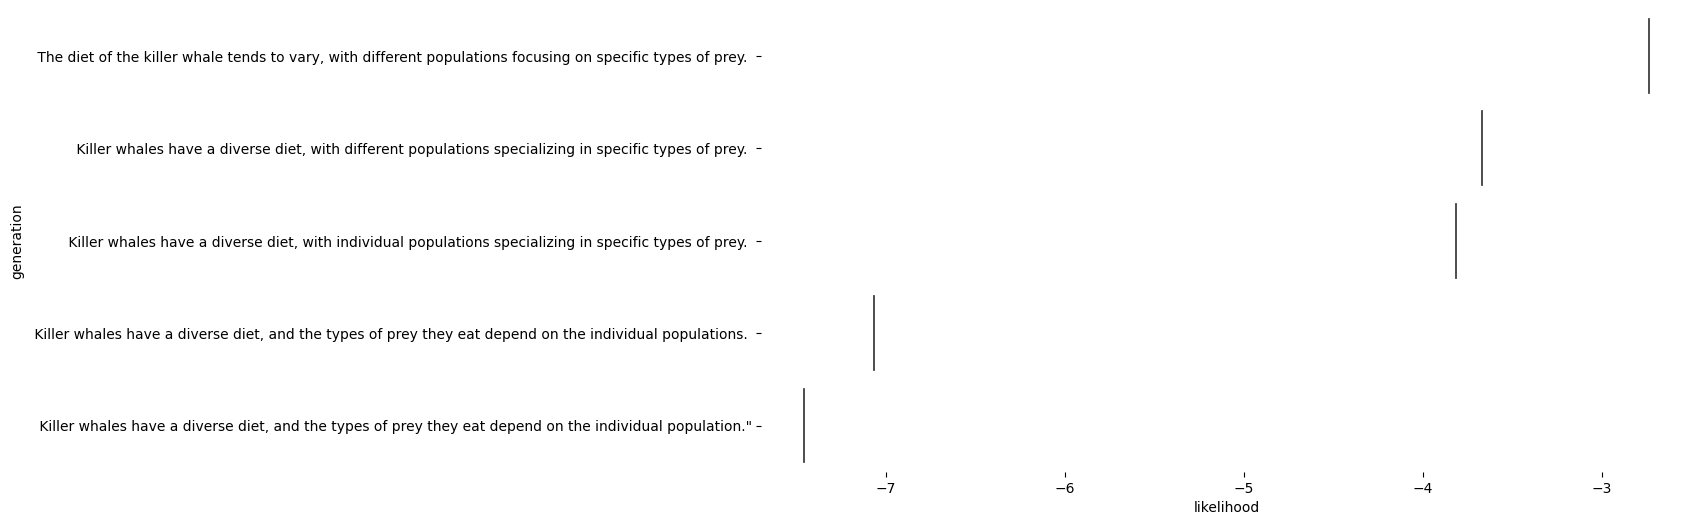

In [ ]:
# @title generation vs likelihood

from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(df['generation'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(df, x='likelihood', y='generation', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

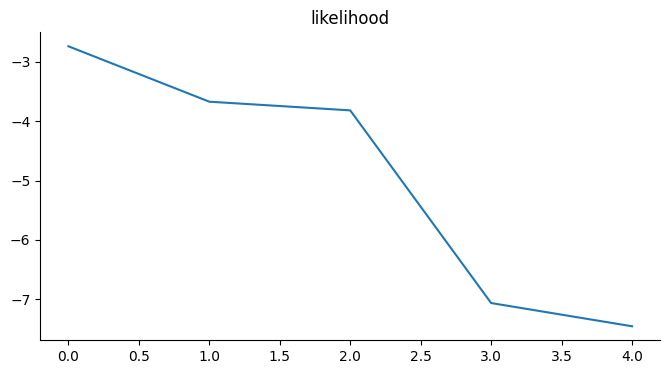

In [ ]:
# @title likelihood

from matplotlib import pyplot as plt
df['likelihood'].plot(kind='line', figsize=(8, 4), title='likelihood')
plt.gca().spines[['top', 'right']].set_visible(False)

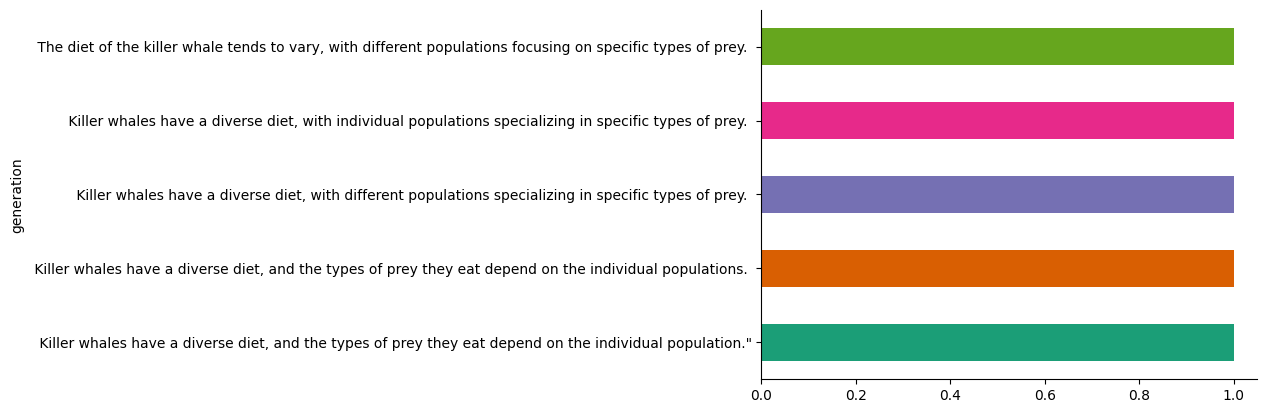

In [ ]:
# @title generation

from matplotlib import pyplot as plt
import seaborn as sns
df.groupby('generation').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

In [ ]:
text= 'Kuvempu studied at Mysuru University in the 1920s, taught there for nearly three decades and served as its vice-chancellor from 1956 to 1960. He initiated education in Kannada as the language medium. For his contributions to Kannada Literature, the Government of Karnataka decorated him with the honorific Rashtrakavi ("National Poet") in 1964 and Karnataka Ratna in 1992. He was conferred the Padma Vibhushan by the Government of India in 1988. He penned the Karnataka State Anthem Jaya Bharata Jananiya Tanujate.'
result = co.summarize(text=text)

print(result)

print(result.summary)

id='bd99605e-2ba5-4972-a2cf-7eb6bd1b7229' summary='Kuvempu studied at Mysuru University and served as vice-chancellor from 1956 to 1960. He initiated education in Kannada as the language medium. He was given several awards for his literary work, including the Padma Vibhushan, India\'s second highest civilian honour, Rashtrakavi ("National Poet") and Karnataka Ratna. He wrote the Karnataka State Anthem Jaya Bharata Jananiya Tanujate.' meta=ApiMeta(api_version=ApiMetaApiVersion(version='1', is_deprecated=None, is_experimental=None), billed_units=ApiMetaBilledUnits(input_tokens=122, output_tokens=84, search_units=None, classifications=None), tokens=None, warnings=None)
Kuvempu studied at Mysuru University and served as vice-chancellor from 1956 to 1960. He initiated education in Kannada as the language medium. He was given several awards for his literary work, including the Padma Vibhushan, India's second highest civilian honour, Rashtrakavi ("National Poet") and Karnataka Ratna. He wrote

In [103]:
#finding similarity between 3 sentences using cosine similarity

listob=['apple is red','apple is red but green apple also is available','kiwi and oranges are different fruits']
df = pd.DataFrame(listob, columns=['text'])

def get_embeddings(texts,model='embed-english-v3.0',input_type="search_document") :
  output = co.embed(texts=listob, model=model, input_type=input_type)
  return output.embeddings

df['query_embeds'] = get_embeddings(df['text'])
df.head()


,text,query_embeds
0,apple is red,"[-0.006828308, 0.018554688, 0.0017900467, 0.01..."
1,apple is red but green apple also is available,"[0.0072364807, 0.022338867, -0.03540039, -0.00..."
2,kiwi and oranges are different fruits,"[-0.02558899, 0.0048179626, -0.016616821, 0.04..."


In [88]:
embeds=np.array(df['query_embeds'].tolist())

In [84]:
def get_similar(candidates):
  candidates=np.array(candidates)

  sim=cosine_similarity(candidates)
  sim=np.squeeze(sim).tolist()
  sort_index=np.argsort(sim)[::-1]
  sort_index = sort_index.flatten().astype(int)
  sort_score=[sim[i] for i in sort_index]
  similarity_score=zip(sort_index,sort_score)
  return similarity_score

In [107]:
similarity=get_similar(embeds)

In [108]:
for idx, sim in enumerate(similarity):
    if idx < len(df):  # Check if idx is within the bounds of the DataFrame
        score = sim[1][0]  # Extract the similarity score from the tuple
        print(f"Similarity:{score:.2f}-{df['text'][idx]}")

Similarity:0.57-apple is red
Similarity:1.00-apple is red but green apple also is available
Similarity:0.62-kiwi and oranges are different fruits


In [105]:
response = co.embed(
    texts=listob,
    model='embed-english-v3.0',
    input_type='search_document'
)

In [104]:
embeddings = response.embeddings

[sentence1, sentence2, sentence3] = embeddings

print("Embedding for sentence 1", np.array(sentence1))
print("Embedding for sentence 2", np.array(sentence2))
print("Embedding for sentence 3", np.array(sentence3))

Embedding for sentence 1 [-0.00682831  0.01855469  0.00179005 ...  0.01457214  0.0289917
 -0.00244522]
Embedding for sentence 2 [ 0.00723648  0.02233887 -0.03540039 ...  0.00682068  0.01368713
  0.00985718]
Embedding for sentence 3 [-0.01190948  0.01576233 -0.0242157  ...  0.0302887  -0.00445938
 -0.00896454]


In [98]:
print("Cosine similarity between sentences 1 and 2:", cosine_similarity([sentence1], [sentence2])[0][0])
print("Cosine similarity between sentences 1 and 3:", cosine_similarity([sentence1], [sentence3])[0][0])
print("Cosine similarity between sentences 2 and 3:", cosine_similarity([sentence2], [sentence3])[0][0])

Cosine similarity between sentences 1 and 2: 0.7459380122073457
Cosine similarity between sentences 1 and 3: 0.6157979897208935
Cosine similarity between sentences 2 and 3: 0.6281013517846834


In [99]:
print("Cosine similarity between sentences 1 and 1:", cosine_similarity([sentence1], [sentence1])[0][0])
print("Cosine similarity between sentences 2 and 2:", cosine_similarity([sentence2], [sentence2])[0][0])
print("Cosine similarity between sentences 3 and 3:", cosine_similarity([sentence3], [sentence3])[0][0])

Cosine similarity between sentences 1 and 1: 1.0000000000000004
Cosine similarity between sentences 2 and 2: 1.0
Cosine similarity between sentences 3 and 3: 1.0


[Text(0.5, 0, 'apple is red'),
 Text(1.5, 0, 'apple is red but green apple also is available'),
 Text(2.5, 0, 'kiwi and oranges are different fruits')]

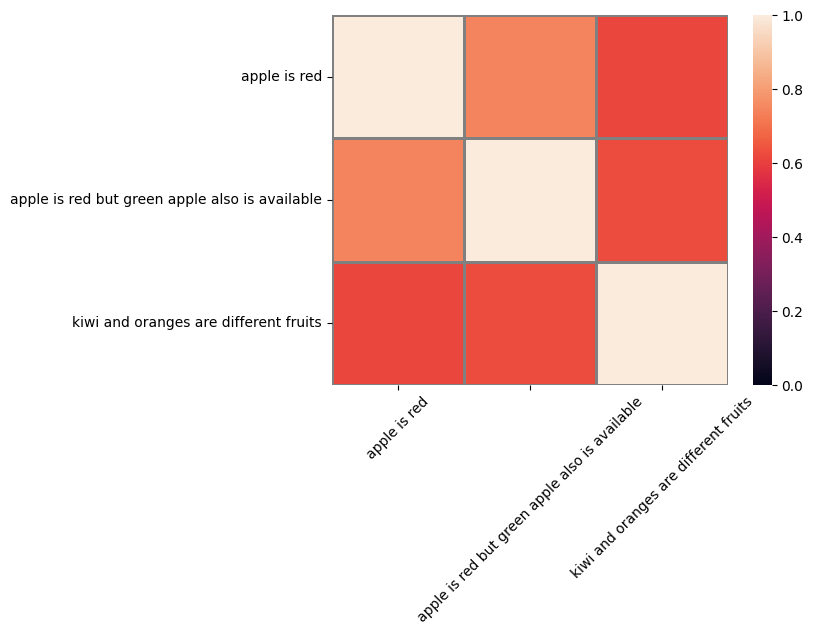

In [106]:
import seaborn as sns
# Get pairwise dot product similarities
dot_product_similarities = [[cosine_similarity([embeddings[i]], [embeddings[j]])[0][0] for i in range(len(embeddings))] for j in range(len(embeddings))]

# Plot in 3x3 grid
ax = sns.heatmap(dot_product_similarities, vmin=0, vmax=1,
                 linewidths=1, linecolor='grey',
                 xticklabels=listob,
                 yticklabels=listob,
)
ax.set_xticklabels(labels=listob, rotation=45)